In [1]:
# Libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
sns.set()

In [2]:
# Load data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The very first step will be to explore the dataset.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


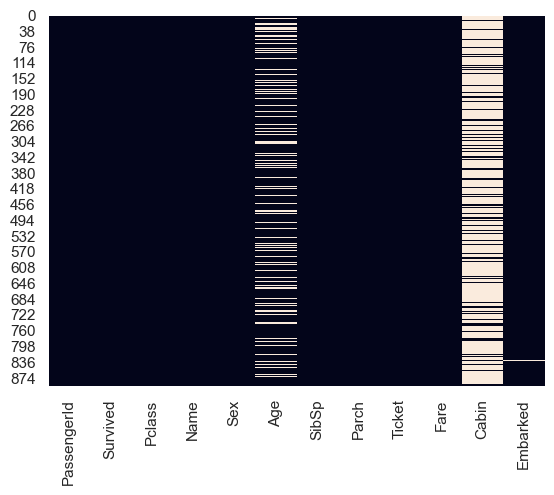

In [5]:
sns.heatmap(train.isna(), cbar=None)
plt.show()

In [6]:
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

We can already notice that the Age and Cabin features have a lot of missing values. Although we can handle the Age feature by filling in those missing values with the median age, we would have trouble doing that with the Cabin attribute, seeing as there is little evident pattern. One idea could be associating Cabin values with Passenger Class. We can assume that the Cabin letter relates to deck, while the number is not particularly important. So, let's fix that.

In [7]:
def preprocess_cabin(text):
    text = re.sub(r'\d+', '', text)
    if len(text) > 1:
        text = text[0]
    return text
train['Cabin'] = train.Cabin.fillna('none')
train['Cabin'] = train.Cabin.apply(preprocess_cabin)

In [8]:
train.Cabin.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

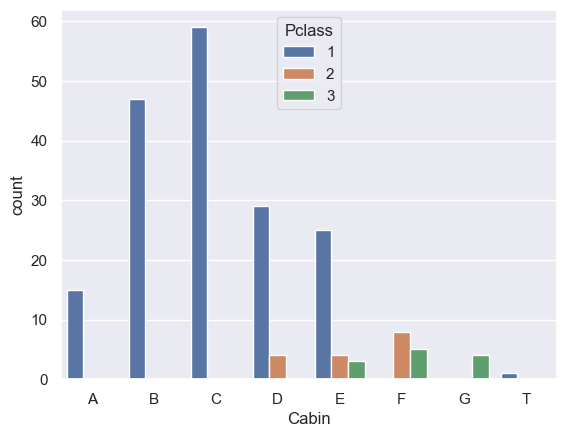

In [9]:
cabin_vc = train[train.Cabin != 'n'].groupby('Cabin')['Pclass'].value_counts().to_frame().reset_index()
sns.barplot(cabin_vc, x='Cabin', y='count', hue='Pclass')
plt.show()

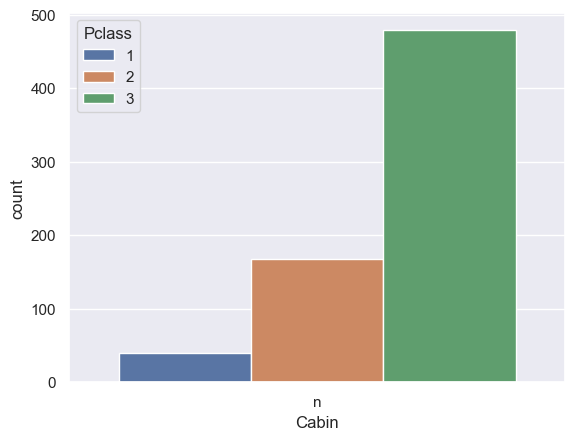

In [10]:
cabin_none = train[train.Cabin == 'n'].groupby('Cabin')['Pclass'].value_counts().to_frame().reset_index()
sns.barplot(cabin_none, x='Cabin', y='count', hue='Pclass')
plt.show()

We can notice two patterns. First, most first class passengers had their cabin listed, while most third class passengers did not. Secondly, a lot more passengers had their cabin listed that those that did not. We can thusly, engineer a new feature that shows whether a passenger had a cabin listed or not and explore how that relates to surviving.

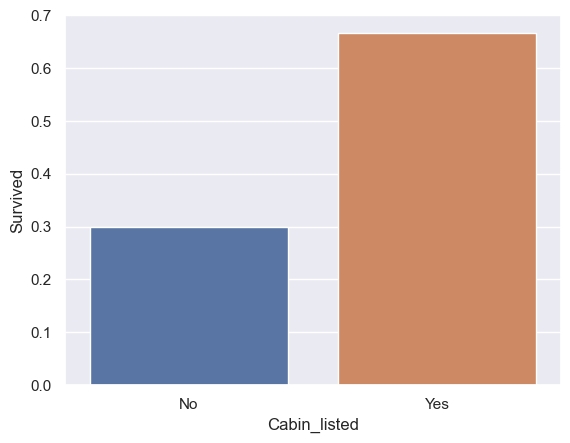

In [11]:
train['Cabin_listed'] = train.Cabin.apply(lambda x: 'No' if x=='n' else 'Yes')
cl_surv = train.groupby('Cabin_listed')['Survived'].mean().to_frame()
sns.barplot(cl_surv, x=cl_surv.index, y='Survived')
plt.show()

We can see that a passenger has a significantly higher chance of surviving when their cabin had been listed. However, we should now check how a passenger class relates to surviving.

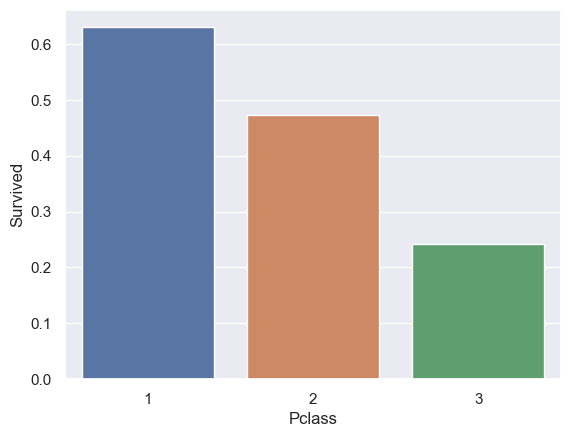

In [12]:
pclass_surv = train.groupby('Pclass')['Survived'].mean().to_frame()
sns.barplot(pclass_surv, x=pclass_surv.index, y='Survived')
plt.show()

Class seems to be significantly related to whether a passenger survived or not. As such, having the cabin listed or not might offer little additional information to a model, with the added caveat of increasing dimensionality. It would then be better to not include it.

The next feature we will investigate is family size. That feature is not readily available in the dataset, therefore we will create it by combining the SibSp and Parch features.

In [13]:
train['family_size'] = train.SibSp + train.Parch + 1 # Plus one for the person themselves. 
test['family_size'] = test.SibSp + test.Parch + 1 
train.family_size.unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

There appears to be a discrepancy in sizes, so we will bin that.

In [14]:
labels = ['solo', 'small family', 'big family', 'very big family']
bins = [0, 1, 4, 7, 11]
train['family_size'] = pd.cut(train.family_size, bins=bins, labels=labels)
test['family_size'] = pd.cut(test.family_size, bins=bins, labels=labels)

Let's see the distribution of family size and how it relates to surviving.

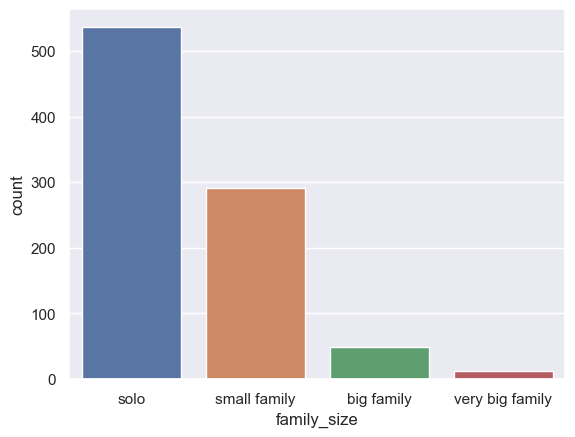

In [15]:
fam_size = train.family_size.value_counts().to_frame()
sns.barplot(fam_size, x=fam_size.index, y='count')
plt.show()

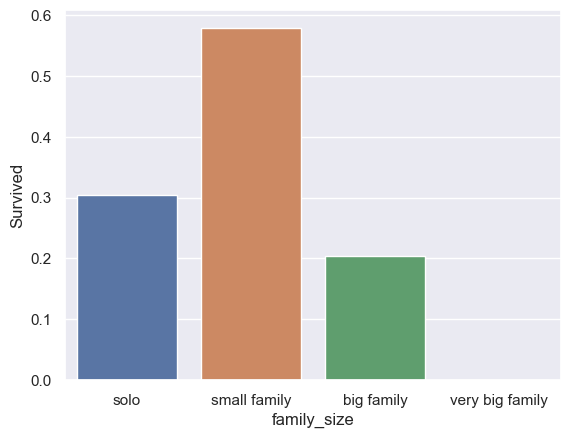

In [16]:
fam_surv = train.groupby('family_size')['Survived'].mean().to_frame()
sns.barplot(fam_surv, x=fam_surv.index, y='Survived')
plt.show()

It appears that small families had a higher chance of surviving. The idea is that smaller families could more easily stick together and help each other surviving, compared to larger families that could have more trouble gathering. 

Let's now investigate how sex relates to surviving.

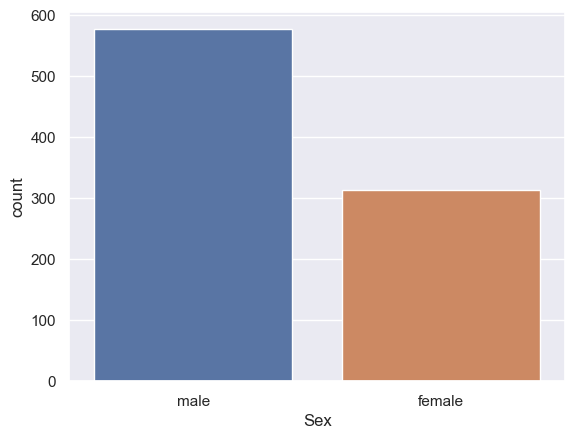

In [17]:
sex_vc = train.Sex.value_counts().to_frame()
sns.barplot(sex_vc, x=sex_vc.index, y='count')
plt.show()

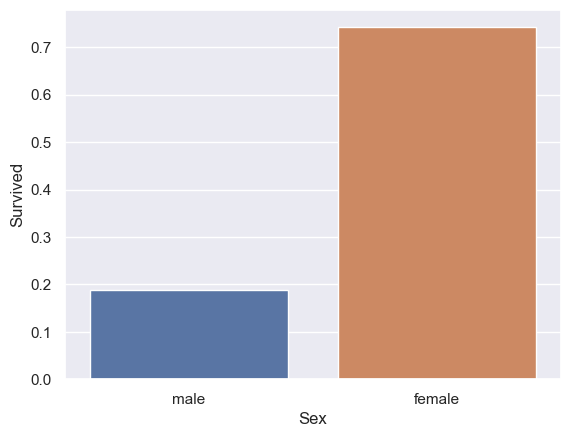

In [18]:
sex_surv = train.groupby('Sex', sort=False)['Survived'].mean().to_frame()
sns.barplot(sex_surv, x=sex_surv.index, y='Survived')
plt.show()

We can see that although a lot more males boarded the Titanic, the majority that survived were females.

Let's explore how a person's age affected their chance for survival. We can see that the Age feature takes many different values, so let's bin that as well.

In [19]:
train.Age.unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [20]:
train['Age'] = train.Age.fillna(train.Age.median())

In [21]:
age_labels = ['Child', 'Young Adult', 'Adult', 'Elder']
age_bins = [0, 14, 22, 55, 100]
train['Age_Cat'] = pd.cut(train.Age, bins=age_bins, labels=age_labels)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_listed,family_size,Age_Cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S,No,small family,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Yes,small family,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S,No,solo,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Yes,small family,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S,No,solo,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,n,S,No,solo,Adult
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B,S,Yes,solo,Young Adult
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,n,S,No,small family,Adult
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,C,Yes,solo,Adult


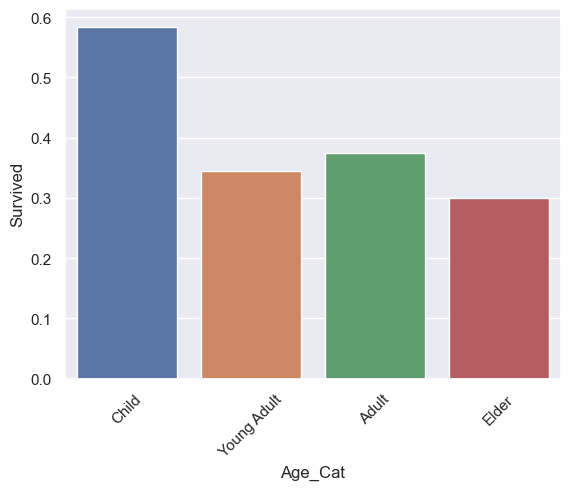

In [46]:
age_surv = train.groupby('Age_Cat')['Survived'].mean().to_frame().reset_index()
sns.barplot(age_surv, x='Age_Cat', y='Survived')
plt.xticks(rotation=45)
plt.show()